In [1]:
# written by Jade Chongsathapornpong, Jan. 2023
# MCSC Climate Scholars Program, Tuller Group, MIT
import numpy as np
from scipy.special import erf, erfc
import pandas as pd
import matplotlib.pyplot as plt
import lmfit

import os

# Fitting conductivity relaxation
When oxygen activity is changed, our material is oxidized or reduced, affecting the defect equilibrium and therefore the conductivity of the sample. On a step change in oxygen activity, this process looks like an exponential relaxation toward the new equilibrium. By fitting this exponential relaxation, we can estimate the rate of oxygen exchange.

With the sample's resistivity normalized within 0 and 1, we have
\begin{equation}
    g(t) = \frac{\rho(t)-\rho_0}{\rho_{t\to\infty} - \rho_0} = 1 - \exp\left(\frac{-k_{c}At}{V}\right) = 1 - \exp\left(\frac{-k_{c}t}{h}\right)
\end{equation}
where $k_c$ is the rate constant for exchange, and $h$ is the thickness of the film (the last equality comes from our thin-film geometry).

In [17]:
#filenames
root = r"C:\Users\jade2\Documents\MetalOxides\PCO10_4k\relax_0.1-0.2"
fn550 = os.path.join(root, "550C_0.1-0.2_150sccm.csv")
fn525 = os.path.join(root, "525C_0.1-0.2_150sccm.csv")
fn500 = os.path.join(root, "500C_0.1-0.2_150sccm.csv")
fn500_2 = os.path.join(root, "500C_0.1-0.2_day2_150sccm.csv")
fn475 = os.path.join(root, "475C_0.1-0.2_day2_150sccm.csv")

In [18]:
# User start here
current_datafile = fn550
df = pd.read_csv(current_datafile)
df

,,Experiment:,Single frequency relaxation 0.1to0.2 200Hz
Start date:,Thursday,November 17,2022.0
Start time:,5:11:02 PM -05:00,NaN,NaN
Time (s),Frequency (Hz),Z' (Ohm),NaN
2,200,382794.3,NaN
4,200,383032.3,NaN
...,...,...,...
1394,200,384800.4,NaN
1396,200,384842.4,NaN
1398,200,384710,NaN
1400,200,384779.7,NaN


In [19]:
df = pd.read_csv(current_datafile, skiprows=3)
print(df.keys())

Index(['Time (s)', ' Frequency (Hz)', ' Z' (Ohm)'], dtype='object')


Now to normalize, we'll pin the minimum and maximum to 0 and 1.

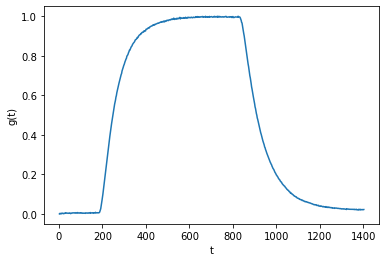

In [20]:
df["Zzero"] = (df[" Z' (Ohm)"] - np.min(df[" Z' (Ohm)"]))
df["Znorm"] = df["Zzero"] / np.max(df["Zzero"])
plt.plot(df['Time (s)'], df['Znorm'])
plt.ylabel("g(t)")
plt.xlabel("t")
plt.show()

Good! Now I'd like to make a parametric model for the relaxation curve. Basically,
\begin{equation}
    g(t) = \begin{cases}
            0 & t < t_0\\
            1 - \exp[-r_o(t-t_0)] & t_0 < t < t_1\\
            \exp[-r_r(t-t_1)] & t_1 < t
        \end{cases}
\end{equation}
where $r = \frac{k_{\rm{chem}}}{h}$ and we will allow $t_0$, $t_1$, an oxidation time constant $r_o$, and reduction time constant $r_r$ to be our free parameters. An additional linear base curve is added as well, to allow better fit to the long relaxations where we observed drift. To smooth out the transitions so the optimizer runs better, I will use an `erf` and `erfc` to interpolate between the steps.

In [24]:
# Hand-tune these parameters to be vaguely like the real data, otherwise the optimizer will fail (because we have tons of params)
t_step1 = 200
t_step2 = 800
r0_guess = 0.005
r1_guess = 0.005
exp_lim1_guess = 0.7
exp_lim2_guess = 0.1
driftslope_guess = 0

dx = 0.1 # if data is longer, this should be set higher (e.g. 1000 timesteps, dx=0.1 whereas with 20000 timesteps, try dx=100)
# or else the function is kinda ill-conditioned and the optimizer will fail.

drift = False # if there is drift, have this True. Else, set it to False and set driftslope_guess to 0 
# or else the optimizer will fail. 

def relaxation_curve(x, x0, x1, r0, r1, exp_lim1, exp_lim2, driftslope):
    '''
    x0 : first PO2 step time
    x1 : second PO2 step time
    r0 : first exponential time constant
    r1 : second exponential time constant
    exp_lim1 : limiting value of first relaxation without drift
    exp_lim2 : limiting value of second relaxation without drift
    driftslope : slope of underlying drift
    '''
    # weighting factors
    # weight0 = 1-(erf((x-x0)/dx) + 1)/2.0
    weight2 = 1-(erfc((x-x1)/dx))/2.0
    weight1 = (erf((x-x0)/dx) + 1 + erfc((x-x1)/dx)) / 2 - 1
    # functions
    return weight1 * (exp_lim1-np.exp(-r0*(x-x0))) + weight2 * (np.exp(-r1*(x-x1)) + exp_lim2) + x * driftslope

curve_model = lmfit.Model(relaxation_curve, independent_vars=['x'])
# Now we can define our free parameters and initialize them.
params = lmfit.Parameters()
params.add('x0', value=t_step1, min=0)
params.add('x1', value=t_step2, min=0)
params.add('r0', value=r0_guess, min=0, max=2)
params.add('r1', value=r1_guess, min=0, max=2)
params.add('exp_lim1', value=exp_lim1_guess)
params.add('exp_lim2', value=exp_lim2_guess)
params.add('driftslope', value=driftslope_guess, vary=drift)

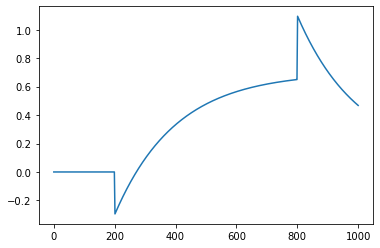

In [25]:
# to hand-tune the initial parameters, mess with the numbers in the previous cell, then re-run to plot here.
x_eval = np.linspace(0, 1000, 1001)
y_eval = curve_model.eval(params, x=x_eval)
plt.plot(x_eval, y_eval)
plt.show()

[[Model]]
    Model(relaxation_curve)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 701
    # variables        = 6
    chi-square         = 0.02006055
    reduced chi-square = 2.8864e-05
    Akaike info crit   = -7321.51701
    Bayesian info crit = -7294.20196
    R-squared          = 0.99984392
[[Variables]]
    x0:          194.887431 +/- 0.13181270 (0.07%) (init = 200)
    x1:          840.515118 +/- 0.14896516 (0.02%) (init = 800)
    r0:          0.01337699 +/- 3.9784e-05 (0.30%) (init = 0.005)
    r1:          0.01063192 +/- 3.2544e-05 (0.31%) (init = 0.005)
    exp_lim1:    0.99734703 +/- 4.0731e-04 (0.04%) (init = 0.7)
    exp_lim2:    0.01778630 +/- 5.3901e-04 (3.03%) (init = 0.1)
    driftslope:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(r1, exp_lim2) = 0.685
    C(x0, r0)       = 0.593
    C(r0, exp_lim1) = -0.547
    C(x1, r1)       = 0.509


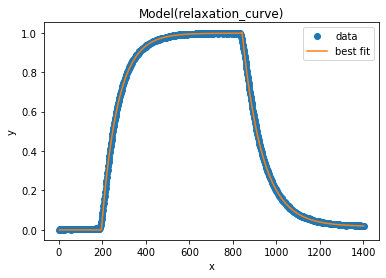

In [26]:
result = curve_model.fit(df['Znorm'].values, x=df['Time (s)'].values, params=params)
result.plot_fit()
print(result.fit_report())

## Results
The fit is quite good in the 550C case. Now recall that $r_0$ is in this case the oxidation (increasing resistivity) time constant, and $r_1$ is the reduction time constant. Since $r = k_{\rm{chem}} / h$ we can obtain $k_{\rm{chem}}$ for each by multiplying by the film thickness $h=85$nm.

In [27]:
# NOTE: The displayed output is not necessarily 550C; check what the current_datafile is
h = 85e-7 # centimeters
k_chem_oxi = result.params["r0"].value * h # cm/s
k_chem_red = result.params["r1"].value * h

print("Oxidation (cm/s):", k_chem_oxi)
print("Reduction (cm/s):", k_chem_red)
try:
    unc_oxi = result.params["r0"].stderr * h
    unc_red = result.params["r1"].stderr * h
    print("Uncertainty (cm/s):", unc_oxi)
    print("Uncertainty (cm/s):", unc_red)
except:
    print("Uncertainty could not be estimated.")

Oxidation (cm/s): 1.1370443293272464e-07
Reduction (cm/s): 9.037131210390886e-08
Uncertainty (cm/s): 3.3816685769953943e-10
Uncertainty (cm/s): 2.766223708153048e-10


According to https://doi.org/10.1016/j.ssi.2019.01.003 (old Clement paper), in PCO10 we can get $k_c = 6\times 10^{-7}$cm/s at 550C. Our result is 6 times slower, at $1.1\times 10^{-7}$cm/s. The statistical uncertainty on this is quite small (0.4\%).

It's worth noting that https://doi.org/10.1016/j.ssi.2019.01.003 (recent Nat. Catal. paper) quotes for the same PCO10 a $k_c$ on the order of $10^{-6}$cm/s, a few times higher still.

That said, we're well within the range of $k_{\rm{chem}}$ achievable through poisoning. But as far as I know, we haven't 100\% confirmed that this is what's happening. Characterizing the surface of our sample for morphology (SEM?) and composition (XPS) would be useful to diagnose the issue.

Another possibility is that our temperatures are systematically lower than they should be, but in a nonlinear fashion. This is possible, because the Linkam stage used to do the measurement is watercooled to <100C, and there is sub-RT gas flowing in steadily, while the sample is on an insulating substrate on the stage at 550C. We would see larger temperature discrepancies at higher stage temperatures.

For this reason, on the new higher quality stage, we're doing a temperature calibration using platinum wire, against a furnace's temperature measurement which is known to be fairly accurate. This should get our temperature uncertainty below 10C, with luck.

### Results: all temperatures
Typical uncertainty of fit is **<1\%, e.g. 0.4\%**.

Typical systematic uncertainty (difference in fitted $r$ values with and without the linear drift in the model, or in cases of low drift, with and without floating the exponential limits) can be around **1-20\%**

Remark: I probably need to improve how the linear drift is calculated in the model function, as there's sharp over/undershoots at the transitions.

In [2]:
T = np.array([550, 525, 500, 500, 475]) + 273 # K
kcoxis = np.array([1.14e-7, 7.30e-8, 4.49e-8, 2.48e-8, 1.82e-8]) # cm/s
kcreds = np.array([9.04e-8, 5.40e-8, 3.45e-8, 2.04e-8, 1.78e-8]) # cm/s
kcoxis_nodrift = np.array([1.11e-7, 7.13e-8, 4.50e-8, 2.75e-8, 1.24e-8])
kcreds_nodrift = np.array([8.73e-8, 4.94e-8, 3.46e-8, 2.01e-8, 0]) # the last value here is fake, the fit basically failed
stat_unc_kcoxis = np.array([3.4e-10, 1.3e-10, 7.4e-11, 6.7e-10, 4.9e-9])
stat_unc_kcreds = np.array([2.8e-10, 1.0e-10, 4.3e-11, 3.8e-10, 0]) # the last value here is fake ""
sys_unc_kcoxis = np.abs(kcoxis - kcoxis_nodrift)
sys_unc_kcreds = np.abs(kcreds - kcreds_nodrift)
drift_slopes = [8e-6, 8e-6, 8.5e-6, 4.7e-5, 1.5e-5] # a normalized impedance drift baseline

We'll now plot these and try to fit an activation energy to them:

[[Model]]
    Model(arrhenius)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 5
    # variables        = 2
    chi-square         = 53.4335151
    reduced chi-square = 17.8111717
    Akaike info crit   = 15.8450013
    Bayesian info crit = 15.0638771
    R-squared          = -8.6556e+15
[[Variables]]
    E:  1.02708810 +/- 0.10664082 (10.38%) (init = 1)
    A:  0.22295734 +/- 0.35656273 (159.92%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(E, A) = 1.000


<AxesSubplot: title={'center': 'Model(arrhenius)'}, xlabel='x', ylabel='y'>

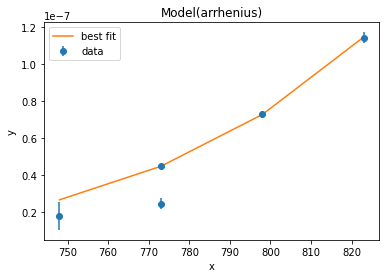

In [5]:
Y = kcoxis
Yerr_weights = 1 / ( np.sqrt(stat_unc_kcoxis**2 + sys_unc_kcoxis**2) ) # lmfit uses 1/sigma, not inverse variance

def arrhenius(x, E, A):
    kB = 8.617333262e-5 # eV/K
    return A * np.exp(-E / (kB * x))

model_a = lmfit.Model(arrhenius, independent_vars=['x'])
params_a = lmfit.Parameters()
params_a.add('E', value=1, min=1e-19)
params_a.add('A', value=10)

resulta = model_a.fit(Y, x=T, params=params_a, weights=Yerr_weights)
print(resulta.fit_report())
resulta.plot_fit()

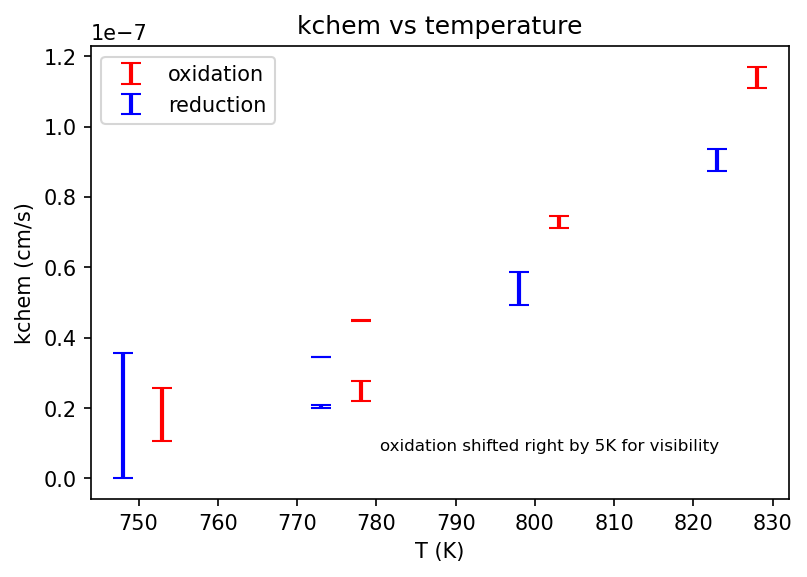

In [8]:
x_eval = np.linspace(700, 900, 10)
y_eval = resulta.eval(params_a, x=x_eval)

fig, ax = plt.subplots()
fig.set_dpi(150)
#ax.plot(x_eval, y_eval, color='blue')
ax.errorbar(T + 5, kcoxis, np.sqrt(stat_unc_kcoxis**2 + sys_unc_kcoxis**2), label='oxidation', color='red', linestyle='', capsize=5, capthick=1, elinewidth=2)
ax.errorbar(T, kcreds, np.sqrt(stat_unc_kcreds**2 + sys_unc_kcreds**2), label='reduction', color='blue', linestyle='', capsize=5, capthick=1, elinewidth=2)
ax.set_title("kchem vs temperature")
ax.set_xlabel("T (K)")
ax.set_ylabel("kchem (cm/s)")
plt.legend()
#ax.set_yscale('log')
ax.text(0.9, 0.1, 'oxidation shifted right by 5K for visibility', verticalalignment ='bottom', horizontalalignment ='right', transform = ax.transAxes, fontsize = 8)
plt.show()